# **BERTweet**
In this Notebook BERTweet is used to classify the types of tweets.
https://huggingface.co/docs/transformers/en/model_doc/bertweet

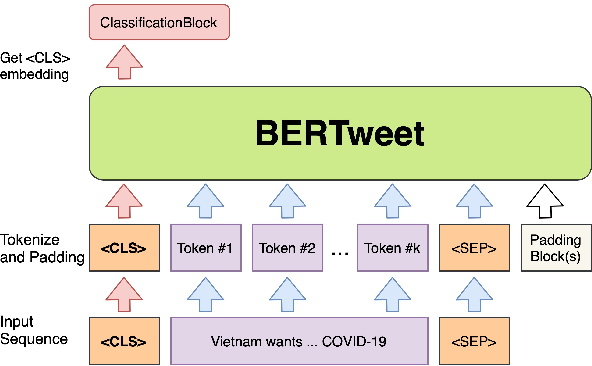

The first public large-scale pre-trained language model for English Tweets. Our BERTweet, having the same architecture as BERT-base (Devlin et al., 2019), is trained using the RoBERTa pre-training procedure (Liu et al., 2019). Experiments show that BERTweet outperforms strong baselines RoBERTa-base and XLM-R-base (Conneau et al., 2020), producing better performance results than the previous state-of-the-art models on three Tweet NLP tasks: Part-of-speech tagging, Named-entity recognition and text classification.

**Import Dependencies**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import torch
from transformers import AutoModel, AutoTokenizer

bertweet = AutoModel.from_pretrained("vinai/bertweet-base")

2024-07-13 17:05:55.494972: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-13 17:05:55.495137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-13 17:05:55.627417: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [2]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the Disaster Tweets

Let's have a look at the train and test dataset.

They contain:


* id
* keyword: A keyword from that tweet (although this may be blank!)
* location: The location the tweet was sent from (may also be blank)
* text: The text of a tweet
* target: 1 if the tweet is a real disaster or 0 if not

In [3]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Explore the dataset

In [6]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


In [7]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [8]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

# Load a BERTweeT model from Huggingface

In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
model_name = "vinai/bertweet-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Tokenize the texts
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(X_val.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True)

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [10]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = TweetDataset(train_encodings, y_train.tolist())
val_dataset = TweetDataset(val_encodings, y_val.tolist())
test_dataset = TweetDataset(test_encodings)


In [11]:
import os
# Disable W&B logging
os.environ["WANDB_DISABLED"] = "true"
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    eval_strategy="epoch",           # use eval_strategy instead of evaluation_strategy
    run_name="bertweet-finetuning",  # set a different run name
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

# Evaluate the model
trainer.evaluate()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,0.453000,0.401534
2,0.391200,0.423370
3,0.324100,0.405406


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.40540561079978943,
 'eval_runtime': 4.6746,
 'eval_samples_per_second': 325.804,
 'eval_steps_per_second': 10.268,
 'epoch': 3.0}

In [12]:
model.save_pretrained('bertweet-disaster-detection')
tokenizer.save_pretrained('bertweet-disaster-detection')

# Load the fine-tuned model for inference
model = AutoModelForSequenceClassification.from_pretrained('bertweet-disaster-detection')
tokenizer = AutoTokenizer.from_pretrained('bertweet-disaster-detection')

**Classifiy Type of Tweet**

In [13]:
def classify_tweet(tweet):
    inputs = tokenizer(tweet, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return 'Disastrous' if torch.argmax(probs) == 1 else 'Not Disastrous'

# Example tweet
tweet = "The hurricane caused massive destruction and flooding in the city."
print(classify_tweet(tweet))


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Disastrous


In [14]:
test_texts = df_test["text"].tolist()
predictions = [classify_tweet(text) for text in test_texts]
print(predictions)

['Disastrous', 'Disastrous', 'Disastrous', 'Disastrous', 'Disastrous', 'Disastrous', 'Not Disastrous', 'Not Disastrous', 'Not Disastrous', 'Not Disastrous', 'Not Disastrous', 'Not Disastrous', 'Not Disastrous', 'Not Disastrous', 'Not Disastrous', 'Disastrous', 'Not Disastrous', 'Not Disastrous', 'Not Disastrous', 'Not Disastrous', 'Not Disastrous', 'Not Disastrous', 'Not Disastrous', 'Disastrous', 'Not Disastrous', 'Disastrous', 'Not Disastrous', 'Not Disastrous', 'Not Disastrous', 'Disastrous', 'Not Disastrous', 'Not Disastrous', 'Not Disastrous', 'Not Disastrous', 'Disastrous', 'Not Disastrous', 'Disastrous', 'Not Disastrous', 'Not Disastrous', 'Disastrous', 'Not Disastrous', 'Disastrous', 'Not Disastrous', 'Disastrous', 'Not Disastrous', 'Not Disastrous', 'Not Disastrous', 'Not Disastrous', 'Disastrous', 'Not Disastrous', 'Not Disastrous', 'Not Disastrous', 'Disastrous', 'Not Disastrous', 'Not Disastrous', 'Not Disastrous', 'Not Disastrous', 'Not Disastrous', 'Not Disastrous', 'Not 

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
val_results = trainer.predict(val_dataset)
val_preds = val_results.predictions.argmax(axis=-1)
val_labels = val_results.label_ids

# Compute and print metrics for the validation set
print("Classification Report:")
print(classification_report(val_labels, val_preds, target_names=['Not Disastrous', 'Disastrous']))

print("Confusion Matrix:")
conf_matrix = confusion_matrix(val_labels, val_preds)
print(conf_matrix)

Classification Report:
                precision    recall  f1-score   support

Not Disastrous       0.85      0.88      0.86       874
    Disastrous       0.83      0.79      0.81       649

      accuracy                           0.84      1523
     macro avg       0.84      0.83      0.84      1523
  weighted avg       0.84      0.84      0.84      1523

Confusion Matrix:
[[765 109]
 [134 515]]


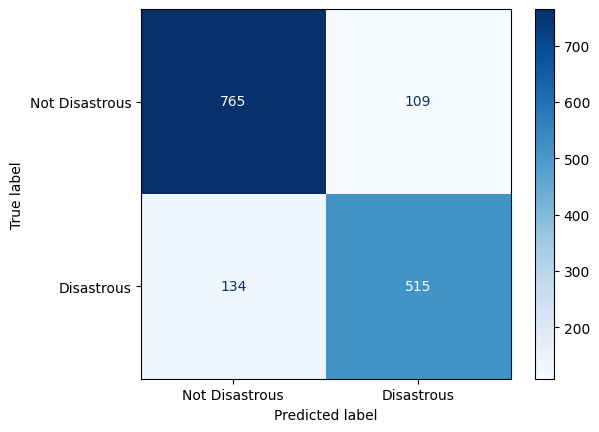

In [16]:
ConfusionMatrixDisplay(conf_matrix, display_labels=['Not Disastrous', 'Disastrous']).plot(cmap=plt.cm.Blues)
plt.show()

In [17]:
from sklearn.metrics import f1_score
f1 = f1_score(val_labels, val_preds)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.8091


In [18]:
test_results = trainer.predict(test_dataset)
test_preds = test_results.predictions.argmax(axis=-1)

# Load sample submission template
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

# Create submission file
submission = sample_submission.copy()
submission['target'] = test_preds
submission.to_csv('submission.csv', index=False)